In [1]:
import torchvision
import random
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import ndarrays_to_parameters, Context
from flwr.server import ServerApp, ServerConfig
from flwr.server import ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation

from utils2 import *

In [2]:

full_trainset = datasets.MNIST(
    "./MNIST_data/", download=True, train=True, transform=transform
)
trainset = Subset(full_trainset, range(1000))

NUM_CLIENTS = 5
DIGITS = list(range(5))

split_size = len(trainset) // NUM_CLIENTS
torch.manual_seed(42)
train_sets = random_split(trainset, [split_size] * NUM_CLIENTS)
train_sets


In [3]:
# Unique exclusions by client
excluded_digits_per_client = []
while len(excluded_digits_per_client) < NUM_CLIENTS:
    exclude = tuple(sorted(random.sample(DIGITS, 3)))
    if exclude not in excluded_digits_per_client:
        excluded_digits_per_client.append(exclude)

# Apply exclusion by client
for i in range(NUM_CLIENTS):
    digits_to_exclude = excluded_digits_per_client[i]
    train_sets[i] = exclude_digits(train_sets[i], excluded_digits=digits_to_exclude)
    print(f"Client {i} excludes the numbers : {digits_to_exclude}")

for i in range(NUM_CLIENTS):
    print(f"Client {i} : {len(train_sets[i])} exemple after exclusion")

train_sets


Client 0 excludes the numbers : (1, 2, 4)
Client 1 excludes the numbers : (1, 2, 3)
Client 2 excludes the numbers : (2, 3, 4)
Client 3 excludes the numbers : (0, 2, 3)
Client 4 excludes the numbers : (0, 3, 4)
Client 0 : 138 exemple after exclusion
Client 1 : 145 exemple after exclusion
Client 2 : 139 exemple after exclusion
Client 3 : 134 exemple after exclusion
Client 4 : 138 exemple after exclusion


In [4]:

full_testset = datasets.MNIST(
    "./MNIST_data/", download=True, train=False, transform=transform
)
testset = Subset(full_testset, range(1000))

client_test_sets = []

all_labels = [label for _, label in testset]

for i in range(NUM_CLIENTS):
    digits_to_exclude = excluded_digits_per_client[i]
    client_test_indices = [
        idx for idx, label in enumerate(all_labels)
        if label not in digits_to_exclude
    ]
    client_test_set = Subset(testset, client_test_indices)
    print(f"[Client {i}] Testset: {len(client_test_set)} images | excludes: {digits_to_exclude}")
    client_test_sets.append(client_test_set)


[Client 0] Testset: 648 images | excludes: (1, 2, 4)
[Client 1] Testset: 651 images | excludes: (1, 2, 3)
[Client 2] Testset: 667 images | excludes: (2, 3, 4)
[Client 3] Testset: 692 images | excludes: (0, 2, 3)
[Client 4] Testset: 698 images | excludes: (0, 3, 4)


In [5]:
# Sets the parameters of the model
def set_weights(net, parameters):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict(
        {k: torch.tensor(v) for k, v in params_dict}
    )
    net.load_state_dict(state_dict, strict=True)

# Retrieves the parameters from the model
def get_weights(net):
    ndarrays = [
        val.cpu().numpy() for _, val in net.state_dict().items()
    ]
    return ndarrays

In [6]:
class FlowerClient(NumPyClient):
    def __init__(self, net, trainset, testset, malicious=False, attack_type="random_label"):
        self.net = net
        self.trainset = trainset
        self.testset = testset
        self.malicious = malicious
        self.attack_type = attack_type

    def invert_image(self, img):
        return 1.0 - img

    def random_label(self):
        for i in range(len(self.trainset)):
            x, y = self.trainset[i]
            self.trainset[i] = (x, random.randint(0,9))

    def targeted(self):
        for i in range(len(self.trainset)):
            x, y = self.trainset[i]
            if y == 1: 
                self.trainset[i] = (x,7)

    def random_input(self):
        for i in range(len(self.trainset)):
            x, y = self.trainset[i]
            if not isinstance(x, torch.Tensor):
                x = transform(x)
            noise = torch.randn_like(x) * 0.3
            self.trainset[i] = (torch.clamp(x + noise, 0.0, 1.0), y)

    def inverted(self):
        for i in range(len(self.trainset)):
            x, y = self.trainset[i]
            self.trainset[i] = (self.invert_image(x), y)
        

    def poison_data(self):
        try:
            if self.attack_type == "random_label":
                self.random_label()
            elif self.attack_type == "targeted":
                self.targeted()
            elif self.attack_type == "random_input":
                self.random_input()
            elif self.attack_type == "inverted":
                self.inverted()
            else:
                print(f"[WARN] Unknown attack type: {self.attack_type}")
        except Exception as e:
            print(f"[ERROR] Poisoning failed ({self.attack_type}): {e}")
            raise e
        

    # Train the model
    def fit(self, parameters, config):
        print(f"fit started for client {partition_id}")
        try:
            set_weights(self.net, parameters)
            partition_id = int(config.get("partition_id", -1))

            if self.malicious:
                print(">>> Malicious client poisoning data...")
                self.poison_data()
                
            train_model(self.net, self.trainset)
            print(f"[Client {partition_id}] training completed successfully")
            return get_weights(self.net), len(self.trainset), {}
        except Exception as e:
            print(f"!!! Client failure: {e}")
            raise e

    # Test the model
    def evaluate(self, parameters: NDArrays, config: Dict[str, Scalar]):
        set_weights(self.net, parameters)
        loss, accuracy = evaluate_model(self.net, self.testset)
        return loss, len(self.testset), {"accuracy": accuracy}

In [7]:
# Client function
def client_fn(context: Context) -> Client:
    
    partition_id = int(context.node_config["partition_id"])
    print(f"### Initialisation of client {partition_id}")
    
    net = SimpleModel()
    client_train = train_sets[int(partition_id)]
    client_test = testset

    malicious_ids = []
    is_malicious = partition_id in malicious_ids

    
    return FlowerClient(
        net, client_train, client_test,
        malicious = is_malicious,
        attack_type="random_input" #targeted, random_input, random_label, inverted
        ).to_client()

In [8]:
client = ClientApp(client_fn)

In [9]:
def evaluate(server_round, parameters, config):
    net = SimpleModel()
    set_weights(net, parameters)

    _, accuracy = evaluate_model(net, testset)
    

    log(INFO, "test accuracy on all digits: %.4f", accuracy)


    if server_round == 5:
        cm = compute_confusion_matrix(net, testset)
        plot_confusion_matrix(cm, "Final Global Model")

In [10]:
net = SimpleModel()
params = ndarrays_to_parameters(get_weights(net))

def server_fn(context: Context):
    strategy = FedAvg(
        fraction_fit=1.0,
        fraction_evaluate=0.0,
        initial_parameters=params,
        evaluate_fn=evaluate,
    )
    config=ServerConfig(num_rounds=5)
    return ServerAppComponents(
        strategy=strategy,
        config=config,
    )

In [11]:
server = ServerApp(server_fn=server_fn)

INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Evaluating initial global parameters
INFO :      test accuracy on all digits: 0.1170
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 0 results and 5 failures
INFO :      test accuracy on all digits: 0.1170
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 0 results and 5 failures
INFO :      test accuracy on all digits: 0.1170
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 0 results and 5 failures
INF

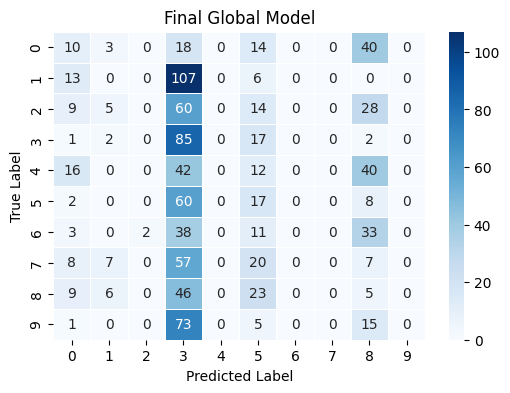

INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 33.04s
INFO :      


In [12]:
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_setup,
)